<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Build a Cycle Generative Adversarial Network model with PyTorch and WML Training Service</b></font></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="1000" alt="Icon"></td>
   </tr>
</table>

This notebook demonstrates how to build a `Cycle Generative Adversarial Network (CycleGAN)` Model in Keras and deploy the model in the `Watson Machine Learning (WML)` repository. 

CycleGAN was proposed by Jun-Yan Zhu et al., in 2017. The goal of `image-to-image` translation is to learn the mapping between an input image and an output image using a training set of aligned image pairs. However, for many tasks, paired training data will not be available. CycleGAN presents an approach for learning to translate an image from a source domain X to a target domain Y in the absence of paired examples[1](#cite). You can check the details of CycleGAN at this <a href="https://arxiv.org/pdf/1703.10593.pdf" target="_blank" rel="noopener noreferrer">link</a>.

In this notebook, the `zebra-to-horse` data set is used to convert `zebra` images to `horse` images and vice versa. You can find the `zebra-to-horse` data set at this <a href="https://dataplatform.test.cloud.ibm.com/exchange/public/entry/view/00d1f36477e7a092a43a264d410d8970" target="_blank" rel="noopener noreferrer">link</a>.

**Note:** Due to the design of the CycleGAN, this notebook takes a while to finish running if the default parameter values are used for training. Hence, the parameter values are set to minimum to train the model in order to avoid reaching `kernel time-out` for the `Lite` plan users. The quality of the results can be improved by using parameters such as `epochs` with greater value. This can be achieved by upgrading your `Watson Machine Learning (WML)` service from `Lite` plan to `Standard` plan which also offers shortened training time. An `image-to-image` translation is a bidirectional process, ex) `horse to zebra` and `zebra to horse`.

This notebook covers the following items: 

- Obtain data.
- Persist training definitions in the Watson Machine Learning (WML) repository.
- Train a CycleGAN model.
- Save the trained CycleGAN model in the Watson Machine Learning (WML) repository.
- Download the trained CycleGAN model from the Cloud Object Storage (COS) or Watson Machine Learning (WML) repository.
- Score the downloaded model locally (Online scoring via `Watson Machine Learning (WML) client V3` is currently not available for `PyTorch`.)

Some familiarity with PyTorch is helpful. This notebook is compatible with Python 3.6 and uses <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html" target="_blank" rel="noopener no referrer">Watson Studio environments.</a>


## Learning goals

In this notebook, you will learn how to:

-  Set up Watson Machine Learning training service to train a CycleGAN model written in PyTorch.
-  Save the trained CycleGAN model in the Watson Machine Learning (WML) repository.
-  Download the trained CycleGAN model from the Watson Machine Learning (WML) repository and score it locally.


## Contents

1. [Set up the environment](#setup)
2. [Explore data](#data)
3. [Create training definitions](#model)
4. [Train the CycleGAN model](#train)
5. [Save the CycleGAN model](#save)
6. [Score the CycleGAN model locally](#score)
7. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before proceeding to the following sections, please perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance.

<div class="alert-block alert-info"><br>
    &nbsp;&nbsp;&nbsp;&nbsp;How to create a <tt>Watson Machine Learning (WML) Service</tt> instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>.<br><br>
</div>

-  Create a <a href="https://cloud.ibm.com/catalog/services/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance. 

<div class="alert-block alert-info"><br>
    &nbsp;&nbsp;&nbsp;&nbsp;How to order the <tt>IBM Cloud Object Storage (COS)</tt> can be found <a href="https://cloud.ibm.com/docs/services/cloud-object-storage/basics?topic=cloud-object-storage-provision#order-storage" target="_blank" rel="noopener no referrer">here</a>.<br><br>
</div>
<br>
<div class="alert alert-block alert-warning">
    When using Watson Studio, you already have a <tt>Cloud Object Storate (COS)</tt> instance associated with the project you are running the notebook.
</div>

- Create new credentials with HMAC: 
    - Go to your COS dashboard.
    - In the **Service credentials** tab, click **New Credential (+)**.
    - Add the inline configuration parameter: {"HMAC":true}, click **Add**.  

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "-------",
            "secret_access_key": "-------"
       }
    ```
    
    <div class="alert-block alert-info"><br>
        &nbsp;&nbsp;&nbsp;&nbsp;More information on <tt>HMAC</tt> can be found <a href="https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-uhc-hmac-credentials-main" target="_blank" rel="noopener no referrer">here</a>.<br><br>
    </div>

In this section, you will learn how to:

- [1.1 Set up the Cloud Object Storage (COS) service](#cos)
- [1.2 Download horse-to-zebra data file and upload it to the Cloud Object Storage (COS) buckets](#mnist)
- [1.3 Set up the Watson Machine Learning (WML) instance](#wml)

### 1.1 Set up the Cloud Object Storage (COS) service <a id="cos"></a>

Install the IBM boto package. This package allows Python developers to manage Cloud Object Storage (COS).

<div class="alert alert-block alert-warning">
    If <tt>ibm_boto3</tt> is not preinstalled in your environment, run the command in the following cell to install it.
    <br><br>
    To simply hide the output of pip install, use <tt>-q</tt> after <tt>!pip install</tt>.
</div>

In [2]:
# Run the command if ibm_boto3 is not installed.
!pip install -q --upgrade pip
!pip install -q --upgrade ibm-cos-sdk

In [3]:
# Import the boto module.
import ibm_boto3
from ibm_botocore.client import Config

Enter your COS credentials in the following cell. 

You can find these credentials in your COS instance dashboard under the **Service credentials** tab.

<div class="alert-block alert-info"><br>
    &nbsp;&nbsp;&nbsp;&nbsp;The <tt>HMAC</tt> key mentioned in the beginning of this section is included in the following Cloud Object Storage (COS) credentials.<br><br>
</div>

In [4]:
cos_credentials = {

}

In [5]:
# The code was removed by Watson Studio for sharing.

Define the endpoint.

To do this, go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information, then copy-and-paste it in the cell below:

In [6]:
# Define endpoint information.
service_endpoint = 'https://s3.us.cloud-object-storage.appdomain.cloud'

You also need the IBM Cloud authorization endpoint to be able to create COS resource object.

In [7]:
# Define the authorization endpoint.
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

Create a Boto resource to be able to write data to COS.

In [8]:
# Create a COS resource.
cos = ibm_boto3.resource(
    's3',
     ibm_api_key_id=cos_credentials['apikey'],
     ibm_service_instance_id=cos_credentials['resource_instance_id'],
     ibm_auth_endpoint=auth_endpoint,
     config=Config(signature_version='oauth'),
     endpoint_url=service_endpoint
)

Create two buckets, which you will use to save training data and training results.

<div class="alert alert-block alert-warning">
    The bucket names must be unique.
</div>

In [9]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = [
    'cycle-gan-training-data-' + bucket_uid,
    'cycle-gan-training-results-' + bucket_uid
]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "cycle-gan-training-data-cb818c7a-ea91-453f-915b-336b41930224"...
Creating bucket "cycle-gan-training-results-cb818c7a-ea91-453f-915b-336b41930224"...


Now, you should have 2 buckets.

In [10]:
# Display a list of created buckets.
print([
    x.name for x in list(cos.buckets.all())
    if x.name.startswith('cycle-gan-training')
])

['cycle-gan-training-data-0eb8b5ad-9443-4235-9cef-7850a803bea5', 'cycle-gan-training-data-1f67b1e5-5f3e-438b-a403-186befe42f4f', 'cycle-gan-training-data-27d09409-6209-4f63-ba57-b4ecc2b6493d', 'cycle-gan-training-data-3a6edb94-bb5a-421d-a13c-1147550a5f90', 'cycle-gan-training-data-84f41b58-b098-4ab9-a6e1-435f59ff8341', 'cycle-gan-training-data-9fcf723f-2279-4aa6-bf22-34227187d1b6', 'cycle-gan-training-data-cb818c7a-ea91-453f-915b-336b41930224', 'cycle-gan-training-data-f7feb425-40b9-4969-99a0-586fcab2169a', 'cycle-gan-training-data-fa35fccb-7881-4b44-9ee7-45c6e5659317', 'cycle-gan-training-data-fd090b2e-7aaf-4d8a-ada4-b4da3da17e73', 'cycle-gan-training-results-0eb8b5ad-9443-4235-9cef-7850a803bea5', 'cycle-gan-training-results-1f67b1e5-5f3e-438b-a403-186befe42f4f', 'cycle-gan-training-results-27d09409-6209-4f63-ba57-b4ecc2b6493d', 'cycle-gan-training-results-3a6edb94-bb5a-421d-a13c-1147550a5f90', 'cycle-gan-training-results-84f41b58-b098-4ab9-a6e1-435f59ff8341', 'cycle-gan-training-resu

### 1.2 Download the `zebra-to-horse` training data files and upload them to the COS buckets <a id="mnist"></a>

Install the `wget` package in order to download the `zebra-to-horse` training data.

In [11]:
!pip install -q --upgrade wget

Import required modules.

In [12]:
from os.path import isfile, join
from wget import download

Download the compressed data file - `zebra2horse.zip`.

<div class="alert-block alert-info"><br>
    &nbsp;&nbsp;&nbsp;&nbsp;The <tt>Zebra-to-Horse</tt> data set can be found <a href="https://dataplatform.test.cloud.ibm.com/exchange/public/entry/view/00d1f36477e7a092a43a264d410d8970" target="_blank" rel="noopener no referrer">here</a>.<br><br>
</div>

In [13]:
zebra_url = (
    'https://api.dataplatform.test.cloud.ibm.com/v2/gallery-assets/entries/' +
    '00d1f36477e7a092a43a264d410d8970/' +
    'data?accessKey=4e6b0754a357d4e805fa4e1d8b0ecb69'
)

In [14]:
filename = 'zebra2horse.zip'

if not isfile(filename):
    filename = download(zebra_url)

Check if the data file is downloaded.

In [15]:
!ls

zebra2horse.zip


Upload the `zebra2horse.zip` file to your Cloud Object Storage (COS).

In [16]:
# Upload files from the links to COS
bucket_obj = cos.Bucket(buckets[0])

print('Uploading data {}...'.format(filename))
bucket_obj.upload_file(Filename=filename, Key=filename)
print('{} is uploaded.'.format(filename))

Uploading data zebra2horse.zip...
zebra2horse.zip is uploaded.


Check the list of the created buckets and each bucket's content.

In [17]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print('\tFile: {}, {:4.2f} kB'.format(obj.key, obj.size/1024))

cycle-gan-training-data-cb818c7a-ea91-453f-915b-336b41930224
	File: zebra2horse.zip, 253.70 kB
cycle-gan-training-results-cb818c7a-ea91-453f-915b-336b41930224


You are done with setting up the Cloud Object Storage (COS) and ready to train your model!

### 1.3 Set up the Watson Machine Learning (WML) instance <a id="wml"></a>

Authenticate the Watson Machine Learning (WML) service on the IBM Cloud.

<div class="alert-block alert-info"><br>
    &nbsp;&nbsp;&nbsp;&nbsp;The <tt>watson-machine-learning-client</tt> documentation can be found <a href="https://wml-api-pyclient-dev.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;Documentation on how to obtain your Watson Machine Learning (WML) service instance credentials can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-get-wml-credentials.html?audience=wdp&linkInPage=true" target="_blank" rel="noopener no referrer">here</a>.<br><br>
</div>

<div class="alert alert-block alert-warning">
    Enter your WML service instance credentials in the following cell.
</div>

In [18]:
wml_credentials = {

}

In [19]:
# The code was removed by Watson Studio for sharing.

Install the `watson-machine-learning-client` package.

In [20]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [21]:
!pip install -q --upgrade watson-machine-learning-client

Import the `watson-machine-learning-client` module and authenticate the service instance.

In [22]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

client = WatsonMachineLearningAPIClient(wml_credentials)

## 2. Explore data <a id="data"></a>

In this section, you will plot some images in the `zebra-to-horse` data set.

First, import the required modules.

In [23]:
from matplotlib.pyplot import subplots, tight_layout
from os import getcwd, listdir
from PIL import Image
from zipfile import ZipFile
%matplotlib inline

Unzip the downloaded data file - `zebra2horse.zip` - mentioned in section [1.2 Download the `zebra-to-horse` training data files and upload them to the COS buckets](#mnist).

In [24]:
pwd = getcwd()

with ZipFile(join(pwd, filename), 'r') as zfin:
    zfin.extractall(pwd)

Check the structure of the unzipped directory.

In [25]:
!ls zebra2horse

trainA	trainB


There are 2 directories - `trainA` and `trainB`. The directories that end with `A`, `B` have images of `zebras`, `horses`, respectively.

Images in directories `trainA` and `trainB` are plotted below.

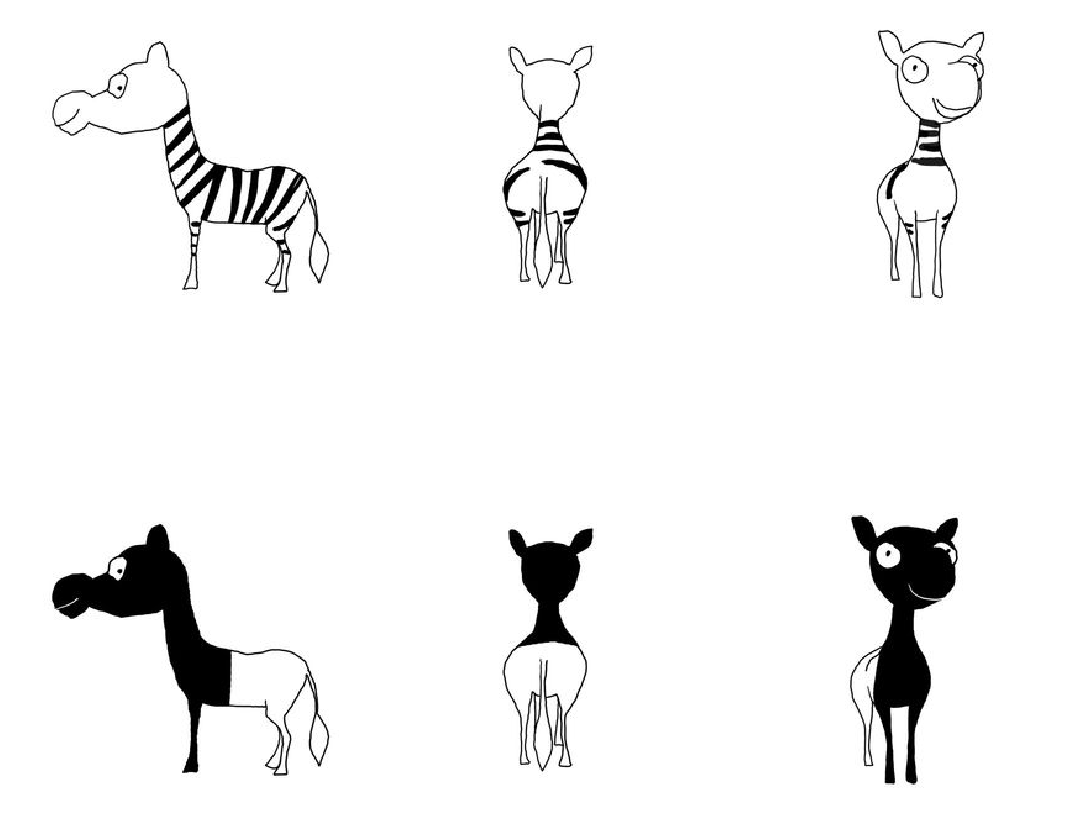

In [26]:
n_rows = 2
n_cols = 3
dir_name = 'zebra2horse'
zebra_dir = 'trainA'
horse_dir = 'trainB'
img_path = join(pwd, dir_name)
img_A = listdir(join(img_path, zebra_dir))
img_B = listdir(join(img_path, horse_dir))

fig, axs = subplots(2, 3, figsize=(15, 15))

for i in range(n_rows):
    for j in range(n_cols):
        if i == 0:
            img = Image.open(join(img_path, zebra_dir, img_A[j]))
        else:
            img = Image.open(join(img_path, horse_dir, img_B[j]))
        axs[i, j].axis('off')
        axs[i, j].imshow(img)
tight_layout()

<a id="model"></a>
## 3. Create the training definitions

In this section, you will:

- [3.1 Create the training definition metadata](#prep)
- [3.2 Download the model definition content file from the GitHub repository](#get)
- [3.3 Store the training definitions in the WML repository](#store)



### 3.1 Create the training definition metadata<a id="prep"></a>

Create the training definition metadata. The main function will be called with enviroment variables `$DATA_DIR` and `$RESULT_DIR` as the inputs for the `--data-dir` and `--result-dir` options.

<div class="alert alert-block alert-warning">
    You may want to add more program arguments - ex) <tt>--epochs</tt> - to the <tt>client.repository.DefinitionMetaNames.EXECUTION_COMMAND</tt> field.
    <br><br>
    Check all default program arguments in the <tt>cycle_gan_pytorch.py</tt> file that is included in the <tt>cycle_gan_pytorch.zip</tt> file.
</div>

In [27]:
model_definition_metadata = {
    client.repository.DefinitionMetaNames.NAME:
    'cycle_gan_training',
    client.repository.DefinitionMetaNames.DESCRIPTION:
    'cycle_gan_training-definition',
    client.repository.DefinitionMetaNames.AUTHOR_NAME:
    'Jihyoung Kim',
    client.repository.DefinitionMetaNames.FRAMEWORK_NAME:
    'pytorch',
    client.repository.DefinitionMetaNames.FRAMEWORK_VERSION:
    '1.1',
    client.repository.DefinitionMetaNames.RUNTIME_NAME:
    'python',
    client.repository.DefinitionMetaNames.RUNTIME_VERSION:
    '3.6',
    client.repository.DefinitionMetaNames.EXECUTION_COMMAND:
    'python3 cycle_gan_pytorch.py --max_size 15 --max_dataset_size 15'
}

### 3.2 Download the model definition content file from the GitHub repository<a id="get"></a>

Download the `cycle_gan_pytorch.zip` file from the `IBMDataScience` GitHub repository.

<div class="alert-block alert-info"><br>
    &nbsp;&nbsp;&nbsp;&nbsp;The <tt>PyTorch</tt> source file that will be used to train the model can be found <a href="https://github.com/IBMDataScience/sample-notebooks/tree/master/Files" target="_blank" rel="noopener no referrer">here</a>.<br><br>
</div>

In [28]:
source_filename = 'cycle_gan_pytorch.zip'

if not isfile(source_filename):
    source_filename = download(
        'https://github.com/IBMDataScience/sample-notebooks/raw/master/' +
        'Files/cycle_gan_pytorch.zip?raw=true'
    )
    
print(source_filename)

cycle_gan_pytorch.zip


### 3.3 Store the training definition in the WML repository<a id="store"></a>

In [29]:
definition_details = client.repository.store_definition(source_filename, model_definition_metadata)

In [30]:
definition_uid = client.repository.get_definition_uid(definition_details)

In [31]:
# Display the training definition uid.
print(definition_uid)

fdb718d3-4b41-4e3d-8c7e-5647678681c0


## 4. Train the CycleGAN model<a id="train"></a>

In this section, you will learn how to:
- [4.1 Configure training metadata](#meta)
- [4.2 Train the model in the background](#backg)
- [4.3 Monitor the training log](#log)
- [4.4 Cancel the training run](#cancel)


### 4.1 Configure training metadata<a id="meta"></a>

- `TRAINING_DATA_REFERENCE` - references the uploaded training data.
- `TRAINING_RESULTS_REFERENCE` - location where the trained model will be saved.

<div class="alert alert-block alert-warning">
    Your <tt>Cloud Object Storage (COS)</tt> credentials are referenced in the training metadata below.
    <br><br>
    You can change the value of <tt>client.training.ConfigurationMetaNames.COMPUTE_CONFIGURATION</tt> in the below cell from <tt>k80</tt> to <tt>v100</tt> for faster computation and better output quality, if you have <tt>Watson Machine Learning</tt> Standard plan.
</div>

In [32]:
# Configure the training metadata for the TRAINING_DATA_REFERENCE and TRAINING_RESULTS_REFERENCE.
training_configuration_metadata = {
    client.training.ConfigurationMetaNames.NAME: 'cycle_gan_training',
    client.training.ConfigurationMetaNames.AUTHOR_NAME: 'Jihyoung Kim',
    client.training.ConfigurationMetaNames.DESCRIPTION:
    'cycle_gan_training_definition',
    client.training.ConfigurationMetaNames.COMPUTE_CONFIGURATION: {
        'name': 'k80' # 'v100' if you are a WML Standard plan user.
    },
    client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
        'connection': {
            'endpoint_url': service_endpoint,
            'access_key_id':
            cos_credentials['cos_hmac_keys']['access_key_id'],
            'secret_access_key':
            cos_credentials['cos_hmac_keys']['secret_access_key']
        },
        'source': {
            'bucket': buckets[0]
        },
        'type': 's3'
    },
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
        'connection': {
            'endpoint_url': service_endpoint,
            'access_key_id':
            cos_credentials['cos_hmac_keys']['access_key_id'],
            'secret_access_key':
            cos_credentials['cos_hmac_keys']['secret_access_key']
        },
        'target': {
            'bucket': buckets[1]
        },
        'type': 's3'
    }
}

### 4.2 Train the model in the background<a id="backg"></a>

To run the training in the **background**, please set the optional parameter `asynchronous` as `True` (or remove it). In this case, the parameter has been removed. 

**Note:** To run the training in **active** mode, please set the optional parameter `asynchronous` as `False`.

In [33]:
training_run_details = client.training.run(definition_uid,
                                           training_configuration_metadata)

In [34]:
training_run_guid_async = client.training.get_run_uid(training_run_details)

Check the status of the training run by calling the method the next cell:

In [35]:
# Get training run status.
from json import dumps

status = client.training.get_status(training_run_guid_async)
print(dumps(status, indent=2))

{
  "current_at": "2020-05-11T19:20:36.157Z",
  "metrics": [],
  "state": "pending",
  "submitted_at": "2020-05-11T19:20:36.157Z"
}


### 4.3  Monitor the training log<a id="log"></a>

<div class="alert alert-block alert-warning">
    For <tt>Lite</tt> plan users, it takes more than <tt>1</tt> hour to complete training while it takes around <tt>15</tt> min for <tt>Standard</tt> plan users.
</div>

Run the cell below to monitor the training log.

In [36]:
from time import time

In [37]:
ts = time()
client.training.monitor_logs(training_run_guid_async)
te = time()



####################################################

Log monitor started for training run: model-rhjns2gc

####################################################


training--ipnKngMg: Training with training/test data at:

training--ipnKngMg:   DATA_DIR: /mnt/data/cycle-gan-training-data-cb818c7a-ea91-453f-915b-336b41930224

training--ipnKngMg:   MODEL_DIR: /job/model-code

training--ipnKngMg:   TRAINING_JOB: 

training--ipnKngMg:   TRAINING_COMMAND: python3 cycle_gan_pytorch.py --max_size 15 --max_dataset_size 15

training--ipnKngMg: Storing trained model at:

training--ipnKngMg:   RESULT_DIR: /mnt/results/cycle-gan-training-results-cb818c7a-ea91-453f-915b-336b41930224/training--ipnKngMg

training--ipnKngMg: Mon May 11 19:20:51 UTC 2020: Running Tensorflow job

training--ipnKngMg: 
training--ipnKngMg: 
training--ipnKngMg: 
training--ipnKngMg: 
training--ipnKngMg: 
training--ipnKngMg: 
training--ipnKngMg: 
training--ipnKngMg: 
training--ipnKngMg: 
training--ipnKngMg: 
training--ipnKngM

In [38]:
print('Time elapsed: {:.2f} min'.format((te - ts) / 60))

Time elapsed: 68.05 min


After training is complete, obtain the training GUID.

In [39]:
training_details = client.training.get_details(training_run_guid_async)
training_guid = training_details['entity']['training_results_reference'][
    'location']['model_location']
print('Training GUID is: {}'.format(training_guid))

Training GUID is: training--ipnKngMg


### 4.4 Cancel the training run<a id="cancel"></a>

You can cancel the training run by calling the method below.

<a id="save"></a>
## 5. Save the CycleGAN model

#### Call this method to the save the trained model in the WML repository.

In [40]:
# Save model in the WML repo.
saved_model_details = client.repository.store_model(
    training_run_guid_async, {'name': 'Cycle GAN model'}
)

In [41]:
# Display location of saved model.
print('Url: {}'.format(client.repository.get_model_url(saved_model_details)))

Url: https://us-south.ml.cloud.ibm.com/v3/wml_instances/7de48772-d7b3-4117-91cd-f94d51b48a20/published_models/8729db60-405a-47fa-a3f7-bab9316ddab1


**Tip:** Run the code below to extract the stored model uid from the dictionary.

In [42]:
# Get and display model uid.
model_uid = client.repository.get_model_uid(saved_model_details)
print('Saved model uid: {}'.format(model_uid))

Saved model uid: 8729db60-405a-47fa-a3f7-bab9316ddab1


#### List stored models.

#### Delete the training run and its results.

Run the code in the cell below to delete train runs and results:

## 6. Score the CycleGAN model locally<a id="score"></a>

<div class="alert alert-block alert-warning">
    Online scoring via <tt>Watson Machine Learning (WML) client V3</tt> is currently not available for <tt>PyTorch</tt>.
</div>

The trained models - `horse-to-zebra` model and `zebra-to-horse` model - must be downloaded either from the `Cloud Object Storage (COS)` bucket created in section [1.1 Set up the Cloud Object Storage (COS) service](#cos) or the `Watson Machine Learning (WML)` repository covered in section [5. Save the CycleGAN model](#save).

The `Cloud Object Storage (COS)` bucket which name starts with `cycle-gan-training-results` has the trained models in it.

### 6.1 Download the trained model from the Cloud Object Storage (COS)

In [43]:
# buckets[1] is the bucket that has the result data and saved model.
bucket_obj = cos.Bucket(buckets[1])

# Model file names as defined in the code (cycle_gan_pytorch.py inside cycle_gan_pytorch.zip.)
saved_model_list = ['gen_AtoB_net.pth', 'gen_BtoA_net.pth']
source_file_list = [
    join(training_guid, 'model', fname) for fname in saved_model_list
]
for i in range(2):
    cos.meta.client.download_file(buckets[1], source_file_list[i],
                                  saved_model_list[i])

Check if the models have been downloaded.

In [44]:
!ls -l gen_AtoB_net.pth gen_BtoA_net.pth

-rw-r----- 1 dsxuser dsxuser 31359096 May 11 20:28 gen_AtoB_net.pth
-rw-r----- 1 dsxuser dsxuser 31359102 May 11 20:28 gen_BtoA_net.pth


### 6.2 Download the trained models from the Watson Machine Learning (WML) repository

Download the trained models from the Watson Machine Learning (WML) repository.

<div class="alert alert-block alert-warning">
    The model file is in <tt>tar.gz</tt> format. If it does not download successfully, check your internet connection, wait a bit and try again.
</div>

In [45]:
client.repository.download(model_uid, 'cycle_gan_model.tar.gz')

Successfully saved artifact to file: 'cycle_gan_model.tar.gz'


'/home/dsxuser/work/cycle_gan_model.tar.gz'

Decompress the model file - `cycle_gan_model.tar.gz`.

In [46]:
!tar xvf cycle_gan_model.tar.gz

gen_BtoA_net.pth
gen_AtoB_net.pth


In [47]:
saved_model_list = ['gen_AtoB_net.pth', 'gen_BtoA_net.pth']

### 6.3 Load the trained model

Install the required Python package - `torch` and `torchvision`.

<div class="alert alert-block alert-warning">
    <tt>torch 1.1.0</tt> and <tt>torchvision 0.3.0</tt> were used to train the models.
</div>

In [48]:
!pip install -q torch==1.1.0
!pip install -q torchvision==0.3.0

**Note**: The following cells in this subsection are included `cycle_gan_pytorch.py` mentioned in section [3.2 Download the model definition content file from the GitHub repository](#get). If you want to explore the details of each function and class, refer to the <a href="https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix" target="_blank" rel="noopener no referrer">CycleGAN GitHub repository</a> created by the authors of the CycleGAN[1](#cite).

Import required modules.

In [49]:
from itertools import chain
from numpy import maximum, tile, transpose, uint8
from random import randint, random, uniform
from torch import cat, cuda, device, no_grad, save, tensor, unsqueeze
from torch.autograd import Variable
from torch.nn import Conv2d, ConvTranspose2d, Dropout, init, InstanceNorm2d,\
     L1Loss, LeakyReLU, Module, MSELoss, ReflectionPad2d, ReLU, Sequential,\
     Tanh
from torch.optim import Adam, lr_scheduler

The `ResnetBlock` class defines a resnet block.

In [50]:
class ResnetBlock(Module):
    def __init__(self, dim, dropout):
        super(ResnetBlock, self).__init__()
        resnet_block = []

        resnet_block.append(ReflectionPad2d(1))
        resnet_block += [
            Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            InstanceNorm2d(dim),
            ReLU(True)
        ]

        if dropout:
            resnet_block.append(Dropout(.5))

        resnet_block.append(ReflectionPad2d(1))
        resnet_block += [
            Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            InstanceNorm2d(dim)
        ]

        self.resnet_block = Sequential(*resnet_block)

    def forward(self, x):
        return x + self.resnet_block(x)

The `Generator` class implements a resnet-based generator that consists of resnet blocks between a few downsampling/upsampling operations.

In [51]:
class Generator(Module):
    def __init__(self, in_ch, out_ch, n_filters=64, n_blocks=6, dropout=False):
        assert(n_blocks >= 0)
        super(Generator, self).__init__()

        model = [
            ReflectionPad2d(3),
            Conv2d(in_ch, n_filters, kernel_size=7, padding=0, bias=True),
            InstanceNorm2d(n_filters),
            ReLU(True)
        ]

        n_sampling = 2

        for i in range(n_sampling):
            mul = 2 ** i

            model += [
                Conv2d(
                    n_filters * mul, n_filters * mul * 2,
                    kernel_size=3, stride=2, padding=1, bias=True
                ),
                InstanceNorm2d(n_filters * mul * 2),
                ReLU(True)
            ]

        for i in range(n_blocks):
            model.append(
                ResnetBlock(
                    n_filters * (2 ** n_sampling), dropout=dropout
                )
            )

        for i in range(n_sampling):
            mul = 2 ** (n_sampling - i)
            model += [
                ConvTranspose2d(
                    n_filters * mul, int(n_filters * mul / 2),
                    kernel_size=3, stride=2, padding=1,
                    output_padding=1, bias=True
                ),
                InstanceNorm2d(int(n_filters * mul / 2)),
                ReLU(True)
            ]

        model.append(ReflectionPad2d(3))
        model.append(Conv2d(n_filters, out_ch, kernel_size=7, padding=0))
        model.append(Tanh())

        self.model = Sequential(*model)

    def forward(self, x):
        return self.model(x)

The `Discriminator` class defines a discriminator.

In [52]:
class Discriminator(Module):
    def __init__(self, in_ch, n_filters=64, n_layers=3):
        super(Discriminator, self).__init__()

        layers = [
            Conv2d(in_ch, n_filters, kernel_size=4, stride=2, padding=1),
            LeakyReLU(0.2, True)
        ]

        mul = 1
        mul_prev = 1

        for n in range(1, n_layers):
            mul_prev = mul
            mul = min(2 ** n, 8)

            layers += [
                Conv2d(
                    n_filters * mul_prev, n_filters * mul, kernel_size=4,
                    stride=2, padding=1, bias=True
                ),
                InstanceNorm2d(n_filters * mul),
                LeakyReLU(0.2, True)
            ]

        mul_prev = mul
        mul = min(2 ** n_layers, 8)

        layers += [
            Conv2d(
                n_filters * mul_prev, n_filters * mul, kernel_size=4,
                stride=1, padding=1, bias=True
            ),
            InstanceNorm2d(n_filters * mul),
            LeakyReLU(0.2, True)
        ]

        layers.append(
            Conv2d(n_filters * mul, 1, kernel_size=4, stride=1, padding=1)
        )
        self.model = Sequential(*layers)

    def forward(self, x):
        return self.model(x)

The `init_net` function initializes a network by: 

1. Registering CPU/GPU device.
2. Initializing the network weights.

In [53]:
def init_net(net, init_gain=0.02):
    def init_func(n):
        class_name = n.__class__.__name__
        if hasattr(n, 'weight') and (
            class_name.find('Conv') != -1 or class_name.find('Linear') != -1
        ):
            init.normal_(n.weight.data, 0., init_gain)

    net.to(device('cpu'))
    return net.apply(init_func)

The `get_scheduler` funtion returns a learning rate scheduler.

In [54]:
def get_scheduler(optimizer):
    def lambda_rule(epoch):
        lr_l = 1. - max(0, epoch - 99) / 101.
        return lr_l
    return lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)

The `ImagePool` class implements an image buffer that stores previously generated images. This buffer is used to update discriminators using a history of generated images rather than the ones produced by the latest generators.

In [55]:
class ImagePool():
    def __init__(self, max_size):
        self.max_size = max_size
        if self.max_size > 0:
            self.imgs_len = 0
            self.images = []

    def sample(self, images):
        if self.max_size == 0:
            return images

        sampled_imgs = []

        for img in images:
            img = unsqueeze(img.data, 0)

            if self.imgs_len < self.max_size:
                self.imgs_len += 1
                self.images.append(img)
                sampled_imgs.append(img)
            else:
                p = uniform(0, 1)
                if p > 0.5:
                    ix = randint(0, self.max_size - 1)
                    tmp_img = self.images[ix].clone()
                    self.images[ix] = img
                    sampled_imgs.append(tmp_img)
                else:
                    sampled_imgs.append(img)

        return cat(sampled_imgs, 0)

The `GANLoss` class abstracts away the need to create the target label tensor that has the same size as the input.

In [56]:
class GANLoss(Module):
    def __init__(self, real_label=1., fake_label=0.):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', tensor(real_label))
        self.register_buffer('fake_label', tensor(fake_label))
        self.loss = MSELoss()

    def get_target_tensor(self, pred, target_is_real):
        target_tensor = self.real_label if target_is_real else self.fake_label
        return target_tensor.expand_as(pred)

    def __call__(self, pred, target_is_real):
        target_tensor = self.get_target_tensor(pred, target_is_real)
        return self.loss(pred, target_tensor)

The `CycleGAN` class implements the CycleGAN model, for learning image-to-image translation without paired data.

In [57]:
class CycleGAN():
    def __init__(
        self, in_ch=3, out_ch=3, dim=3, n_filters=64, n_blocks=6, n_layers=3,
        lr=.0002, beta1=.5, beta2=.999, lambda_A=10., lambda_B=10.,
        lambda_idt=.5, init_gain=.02, max_size=50, dropout=False,
        is_train=True, cuda=True
    ):
        self.is_train = is_train
        self.lambda_idt = lambda_idt
        self.lambda_A = lambda_A
        self.lambda_B = lambda_B
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.device = device('cuda' if cuda else 'cpu')
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.n_filters = n_filters
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.dim = dim
        self.init_gain = init_gain
        self.max_size = max_size
        self.dropout = dropout
        self.optimizers = []
        self.model_list = []

        gen_A = Generator(
            self.in_ch, self.out_ch, self.n_filters, self.n_blocks,
            self.dropout
        )
        self.gen_AtoB = init_net(gen_A, self.init_gain)
        gen_B = Generator(
            self.in_ch, self.out_ch, self.n_filters, self.n_blocks,
            self.dropout
        )
        self.gen_BtoA = init_net(gen_B, self.init_gain)

        if self.is_train:
            self.model_names = ['gen_AtoB', 'gen_BtoA']

            d_A = Discriminator(self.dim, self.n_filters, self.n_layers)
            self.disc_A = init_net(d_A)
            d_B = Discriminator(self.dim, self.n_filters, self.n_layers)
            self.disc_B = init_net(d_B)

            if self.lambda_idt > 0.0:
                assert(self.in_ch == self.out_ch)

            self.fake_A_pool = ImagePool(self.max_size)
            self.fake_B_pool = ImagePool(self.max_size)
            self.crit_GAN = GANLoss().to(self.device)
            self.crit_cycle = L1Loss()
            self.crit_idt = L1Loss()
            self.opt_gen = Adam(
                chain(self.gen_AtoB.parameters(), self.gen_BtoA.parameters()),
                lr=self.lr, betas=(self.beta1, self.beta2)
            )
            self.opt_disc = Adam(
                chain(self.disc_A.parameters(), self.disc_B.parameters()),
                lr=self.lr, betas=(self.beta1, self.beta2)
            )
            self.optimizers.append(self.opt_gen)
            self.optimizers.append(self.opt_disc)
            self.schedulers = [
                get_scheduler(optimizer) for optimizer in self.optimizers
            ]

    def set_input(self, images):
        self.real_A = images['A'].to(self.device)
        self.real_B = images['B'].to(self.device)
        self.image_paths = images['A_paths']

    def forward(self):
        if self.is_train:
            self.gen_AtoB = (
                self.gen_AtoB if next(self.gen_AtoB.parameters()).is_cuda
                else self.gen_AtoB.to(self.device)
            )
            self.gen_BtoA = (
                self.gen_BtoA if next(self.gen_BtoA.parameters()).is_cuda
                else self.gen_BtoA.to(self.device)
            )
        else:
            assert(len(self.model_list) > 0)
            self.gen_AtoB = self.model_list[0]
            self.gen_BtoA = self.model_list[1]

        self.fake_B = self.gen_AtoB(self.real_A)
        self.reconstruct_A = self.gen_BtoA(self.fake_B)
        self.fake_A = self.gen_BtoA(self.real_B)
        self.reconstruct_B = self.gen_AtoB(self.fake_A)

    def backward_disc(self, disc, real, fake):
        pred_real = disc(real)
        loss_disc_real = self.crit_GAN(pred_real, True)

        pred_fake = disc(fake.detach())
        loss_disc_fake = self.crit_GAN(pred_fake, False)

        loss_disc = (loss_disc_real + loss_disc_fake) * 0.5
        loss_disc.backward()
        return loss_disc

    def backward_disc_A(self):
        fake_B = self.fake_B_pool.sample(self.fake_B)
        self.loss_disc_A = self.backward_disc(self.disc_A, self.real_B, fake_B)

    def backward_disc_B(self):
        fake_A = self.fake_A_pool.sample(self.fake_A)
        self.loss_disc_B = self.backward_disc(self.disc_B, self.real_A, fake_A)

    def backward_gen(self):
        lambda_idt = self.lambda_idt
        lambda_A = self.lambda_A
        lambda_B = self.lambda_B

        if lambda_idt > 0:
            self.idt_A = self.gen_AtoB(self.real_B)
            self.loss_idt_A = (
                self.crit_idt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            )
            self.idt_B = self.gen_BtoA(self.real_A)
            self.loss_idt_B = (
                self.crit_idt(self.idt_B, self.real_A) * lambda_A * lambda_idt
            )
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        self.loss_gen_AtoB = self.crit_GAN(self.disc_A(self.fake_B), True)
        self.loss_gen_BtoA = self.crit_GAN(self.disc_B(self.fake_A), True)
        self.loss_cycle_A = (
            self.crit_cycle(self.reconstruct_A, self.real_A) * lambda_A
        )
        self.loss_cycle_B = (
            self.crit_cycle(self.reconstruct_B, self.real_B) * lambda_B
        )

        self.loss_gen = (
            self.loss_gen_AtoB + self.loss_gen_BtoA + self.loss_cycle_A +
            self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        )
        self.loss_gen.backward()

    def set_requires_grad(self, nn, requires_grad=False):
        if not isinstance(nn, list):
            nn = [nn]

        for net in nn:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

    def optimize_params(self):
        self.forward()

        self.set_requires_grad([self.disc_A, self.disc_B])
        self.opt_gen.zero_grad()
        self.backward_gen()
        self.opt_gen.step()

        self.set_requires_grad([self.disc_A, self.disc_B], True)
        self.opt_disc.zero_grad()
        self.backward_disc_A()
        self.backward_disc_B()
        self.opt_disc.step()

    def update_learning_rate(self):
        for scheduler in self.schedulers:
            scheduler.step()

        return self.optimizers[0].param_groups[0]['lr']

    def save_networks(self, path):
        for name in self.model_names:
            if isinstance(name, str):
                filename = '{}_net.pth'.format(name)
                net = getattr(self, name)
                save(net.cpu().state_dict(), join(path, filename))

    def eval(self):
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, name)
                net.eval()

    def set_model_list(self, model_list):
        self.model_list = model_list

    def test(self):
        with no_grad():
            self.forward()
            img_dict = {}

            for i in range(2):
                image_tensor = (
                    self.fake_B.data if i % 2 == 0 else self.fake_A.data
                )
                image_numpy = image_tensor[0].cpu().float().numpy()

                if image_numpy.shape[0] == 1:
                    image_numpy = tile(image_numpy, (3, 1, 1))

                image_numpy = (
                    (transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
                )
                k = 'AtoB' if i % 2 == 0 else 'BtoA'
                img_dict[k] = image_numpy.astype(uint8)

            return img_dict

Since the `fake` images are generated by the `Generator`, `Generators` that transform `horse` to `zebra` and vice versa will be created.

In [58]:
gen_AtoB = Generator(3, 3)
gen_BtoA = Generator(3, 3)

Load the downloaded trained models', `Generators` in this notebook, learned parameters.

In [59]:
from torch import load

gen_AtoB.load_state_dict(load(saved_model_list[0]))
gen_BtoA.load_state_dict(load(saved_model_list[1]))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Call the `eval()` method to set dropout and instance normalization layers to evaluation mode before running inference.

In [60]:
gen_AtoB.eval()

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (resnet_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256,

In [61]:
gen_BtoA.eval()

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (resnet_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256,

Instantiate a `CycleGAN` object. Make sure both `is_train` and `cuda` arguments are set as `False`. `is_train` argument must be set as `False` in order to perform testing. `cuda` argument must be set as `False` since the `Watson Studio` notebook service does not support `GPU` runtime. `GPU` runtime is only supported via the `Deep Learning as a Service (DLaaS)` covered in section 4. [Train the CycleGAN model](#train).

Pass the model list - `gen_AtoB` and `gen_BtoA` -  that will be tested to the `CycleGAN` object's `set_model_list` method.

In [62]:
cycle_gan = CycleGAN(in_ch=1, out_ch=1, dim=1, is_train=False, cuda=False)
model_list = [gen_AtoB, gen_BtoA]
cycle_gan.set_model_list(model_list)

### 6.4 Score

Since the `CycleGAN` object takes a custom input object - `ZebraToHorseDataset`, `ZebraToHorseDataset` class and functions that are included in the `ZebraToHorseDataset` class are defined in this section.

First, import required Python packages.

In [63]:
from os import walk
from os.path import isdir
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Grayscale, Lambda, Normalize, RandomCrop, Resize, ToTensor

The `is_image_file` function checks if the image file's extension is in `IMG_EXTENSIONS`.

In [64]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
    '.tif', '.TIF', '.tiff', '.TIFF',
]

def is_image_file(file_name):
    return any(file_name.endswith(ext) for ext in IMG_EXTENSIONS)

The `make_dataset` function returns a list of images given the path of directory where images are located and the maximum number images in the returned list.

In [65]:
def make_dataset(dir_name, max_dataset_size=float('inf')):
    images = []
    assert isdir(dir_name), '{} is not a valid directory'.format(dir_name)

    for root, _, files in sorted(walk(dir_name)):
        for f in files:
            if is_image_file(f):
                path = join(root, f)
                images.append(path)
    return images[:min(max_dataset_size, len(images))]

The `__crop` function crops the image based on the `size` argument.

In [66]:
def __crop(img, pos, size):
    ow, oh = img.size
    x1, y1 = pos
    tw = th = size
    if (ow > tw or oh > th):
        return img.crop((x1, y1, x1 + tw, y1 + th))
    return img

The `get_transform` function returns a list of transformed images.

In [67]:
def get_transform(params=None, grayscale=False, method=Image.BICUBIC, convert=True):
    transform_list = []
    
    if grayscale:
        transform_list.append(Grayscale(1))
        
    osize = [286, 286]
    transform_list.append(Resize(osize, method))
    
    if params is None:
        transform_list.append(RandomCrop(256))
    else:
        transform_list.append(
            Lambda(lambda img: __crop(img, params['crop_pos'], 256))
        )
    
    if convert:
        transform_list += [ToTensor()]

        if grayscale:
            transform_list += [Normalize((0.5,), (0.5,))]
        else:
            transform_list += [Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

    return Compose(transform_list)

The `ZebraToHorseDataset` class creates a dictionary of transformed source images ('A'), transformed destination images ('B'), and path of each group of images.

In [68]:
class ZebraToHorseDataset(Dataset):
    def __init__(self, dataroot, phase, max_dataset_size=float('inf')):
        self.dir_A = join(dataroot, phase + 'A')
        self.dir_B = join(dataroot, phase + 'B')

        self.A_paths = sorted(make_dataset(self.dir_A, max_dataset_size))
        self.B_paths = sorted(make_dataset(self.dir_B, max_dataset_size))

        self.A_size = len(self.A_paths)
        self.B_size = len(self.B_paths)
        
        self.transform_A = get_transform()
        self.transform_B = get_transform()
    
    def __len__(self):
        return max(self.A_size, self.B_size)
    
    def __getitem__(self, ix):
        A_path = self.A_paths[ix % self.A_size]
        ix_B = ix % self.B_size

        B_path = self.B_paths[ix_B]
        A_img = Image.open(A_path).convert('RGB')
        B_img = Image.open(B_path).convert('RGB')

        A = self.transform_A(A_img)
        B = self.transform_B(B_img)

        return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path}

Instantiate the `ZebraToHorseDataset` object. Set the `phase` argument of the constructor of the class as `train` since images from `trainA` and `trainB` will be selected. Set the `max_dataset_size` argument as `3` since only 3 images will be tested.

In [69]:
z2h_dataset_test = ZebraToHorseDataset('zebra2horse', 'train', 3)

In [70]:
dataset_test = DataLoader(z2h_dataset_test,
                          batch_size=1,
                          shuffle=1,
                          num_workers=4)

Score the model - 3 images for `zebra` to `horse` model (`gen_AtoB`) and 3 images for `horse` to `zebra` model (`gen_BtoA`).

In [71]:
z2h_imgs = []
h2z_imgs = []

for i, data in enumerate(dataset_test):
    cycle_gan.set_input(data)
    z2h_imgs.append(cycle_gan.test()['AtoB'])
    h2z_imgs.append(cycle_gan.test()['BtoA'])

Plot the scored images.

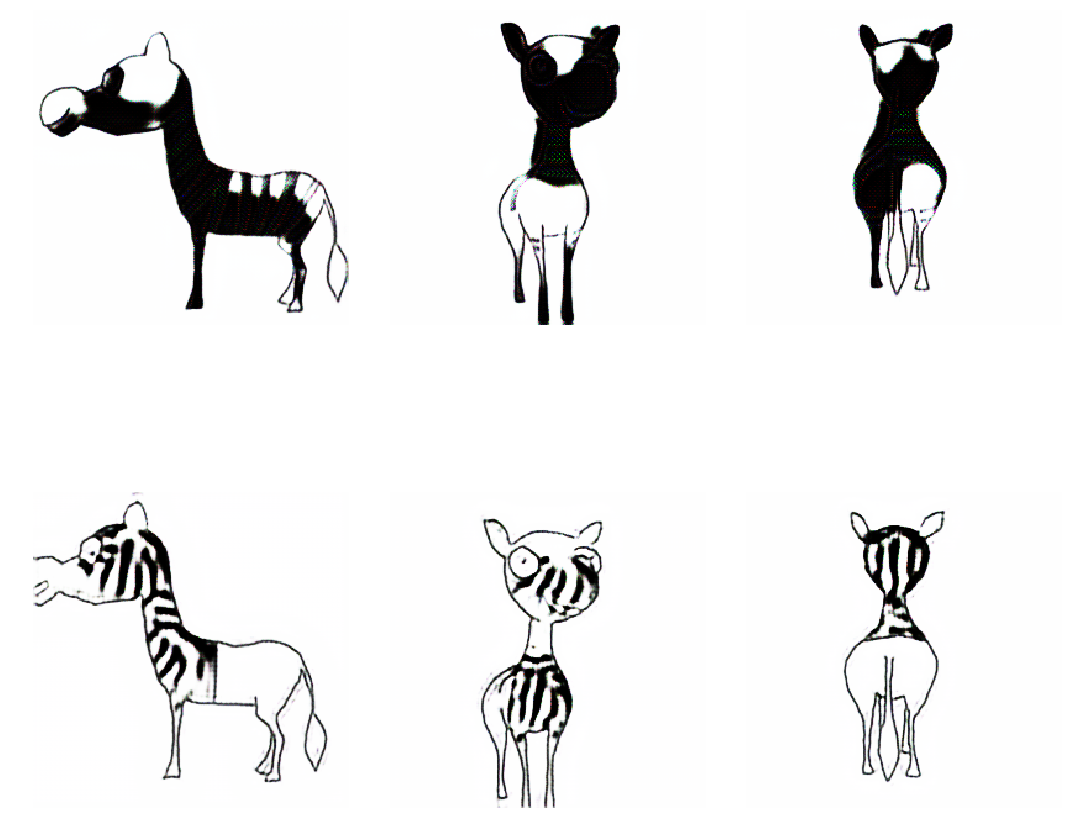

In [72]:
fig, axs = subplots(2, 3, figsize=(15, 15))

for i in range(n_rows):
    for j in range(n_cols):
        img = z2h_imgs[j] if i == 0 else h2z_imgs[j]
        axs[i, j].axis('off')
        axs[i, j].imshow(img)
tight_layout()

You can see the transformations of `zebra` to `horse` and vice versa are relatively satisfactory. As mentioned in the introduction, the results can be `drastically` improved by tweaking the parameters, and this can be achieved by upgrading to `Standard` plan that offers faster computation and much longer kernel time-out value.

<a id="summary"></a>
## 7. Summary and next steps     

You successfully completed this notebook! 
 
You have learned how to:
- Train a `Cycle Generative Adversarial Network (CycleGAN)` model in PyTorch using the `Watson Machine Learning (WML)` training service.
- Save the `Cycle Generative Adversarial Network (CycleGAN)` model in the `Watson Machine Learning (WML)` repository.
- Download the `Cycle Generative Adversarial Network (CycleGAN)` model from the `Cloud Object Storage (COS)` or `Watson Machine Learning (WML)` repository.
- Score the `Cycle Generative Adversarial Network (CycleGAN)` model locally.
 
### Resources <a id="resources"></a>

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success">

<h4>IBM documentation</h4>
<ul>
 <li><a href="https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-getting-started" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a></li> 
 <li><a href="https://wml-api-pyclient-dev.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
</ul>

<h4> IBM Samples</h4>
<ul>
 <li><a href="https://dataplatform.cloud.ibm.com/gallery" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
</ul>

<h4> Others</h4>
<ul>
 <li><a href="https://www.python.org" target="_blank" rel="noopener noreferrer">Official Python website</a></li>
 <li><a href="https://pytorch.org/" target="_blank" rel="noopener noreferrer">Official PyTorch website</a></li>
 <li><a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
</ul>
 </div>

### Reference <a id="cite"></a>
1. *Jun-Yan Zhu et al.*, **Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks**, International Conference on Computer Vision, 2017.

### Author

**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who contributes to Watson Studio in order to democratize data science.

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>